In [2]:
import pandas as pd
import os
import requests
import json
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_tweet_history():
    df_old = pd.read_csv("./data/twitter_database.csv")
    df_old = df_old[['text',"created_at"]]
    df_old['created_at'] = pd.to_datetime(df_old['created_at'])
    df_old['created_at'] = df_old['created_at'].astype('datetime64[ns]')
    return df_old

In [4]:
def get_new_tweets():

    #getting the texts
    url = 'https://twitter.com/realdonaldtrump'
    html = requests.get(url).content
    soup = BeautifulSoup(html, 'lxml')
    tags = soup.find_all('p', {'class':'TweetTextSize TweetTextSize--normal js-tweet-text tweet-text'})
    tw_raw = [element.text for element in tags]
    new_tw = pd.DataFrame(tw_raw)
    
    #getting the date 
    url2 = 'https://twitter.com/realdonaldtrump'
    html = requests.get(url2).content
    soup = BeautifulSoup(html, 'lxml')
    tags = soup.find_all('span' , {'_timestamp js-short-timestamp js-relative-timestamp'})
    time_raw = [element for element in tags]
    time = re.findall('\d\d\d\d\d\d\d\d\d\d', str(time_raw))
    time = pd.to_datetime(time ,unit='s')

    
    df_new =pd.DataFrame([tw_raw, time])
    df_new = df_new.transpose()
    df_new = df_new.rename(columns={0: "text", 1: "created_at"})
    df_new['created_at'] =  df_new['created_at'].astype('datetime64[ns]')
    return df_new


In [5]:

def merge_and_sort():
    history = get_tweet_history()
    new = get_new_tweets()
    merged_df = pd.DataFrame(pd.merge( history , new, how = 'outer'))
    merged_df = merged_df.sort_values('created_at', ascending = True)
    merged_df = merged_df.fillna('No Value')
    return merged_df


In [6]:
def find_significance():
    merged_df = pd.DataFrame(merge_and_sort()) 
    list_tx = []
    list_dt = []

    for i in range (len(merged_df)):
        if re.search('China' ,merged_df['text'].iloc[i]):
            list_tx.append(merged_df['text'].iloc[i])
            list_dt.append(merged_df['created_at'].iloc[i])

    df_tx = pd.DataFrame(list_tx, columns = ['text'] )
    df_dt = pd.DataFrame(list_dt, columns = ['created_at']) 
    df = pd.concat([df_tx, df_dt], axis = 1)
    return df


In [7]:
def get_market_data():
    df = pd.read_csv("./data/S&P 500 Historical Data.csv")
    df = df [['Date', 'Price']]
    df['Price'] = df['Price'].str.replace(",", "")
    return df


In [8]:
def plotter():
    df = get_market_data()
    plt.figure(figsize = (25,15))
    plt.title ('S&P 500')
    plt.xlabel ('DATE')
    plt.ylabel ('Price')
    graph = plt.plot (df['Date'], df['Price'].astype('float'))
    return graph



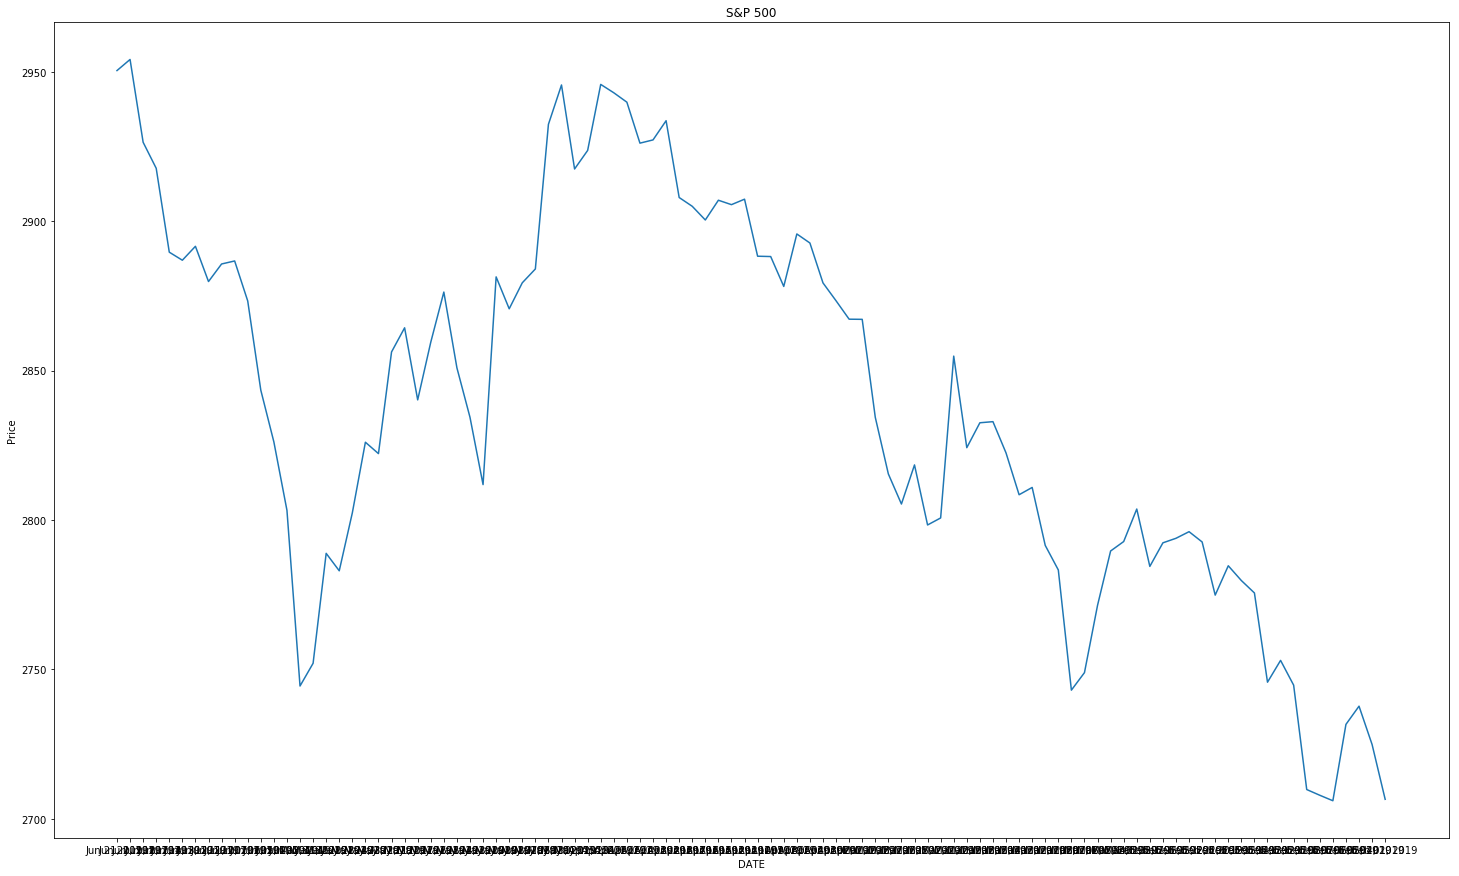

In [9]:
def save_chart():
    fig = plotter()
    fig.show
    fig.savefig(graph + '.png')
    
df = find_significance()
export_csv = df.to_csv ( "./data/twitter_database.csv", index = None, header=True)

plotter()
    
